In [32]:
import os
import sys
import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML
from sklearn.datasets import load_iris
from pystout import pystout
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# Global Settings
pd.set_option("display.float_format", lambda x: "%.4f" % x)

In [34]:
cwd = os.getcwd()
# Find and import config file
config_path = os.getcwd()

sys.path.append(config_path)
import config

database = config.database
central_banks = config.central_banks
training_data = os.path.join(database, "Training Data")
fed_docs = config.fed_docs
ecb_docs = config.ecb_docs
boe_docs = config.boe_docs

In [35]:
test = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor.csv"
)

In [36]:
sentiment = pd.date_range(start="1/1/1990", end="12/31/2024", freq="D")
sentiment = pd.DataFrame(sentiment, columns=["date"])

In [37]:
# Import inflation probability data that is stored as a dta file
inflation_prob_us = pd.read_stata(
    "/Users/kylenabors/Documents/Database/Other Data/Inflation Probabilities/USwestimates.dta"
)

inflation_prob_us = inflation_prob_us.rename(columns={"date_ym": "date"})

inflation_prob_eu = pd.read_stata(
    "/Users/kylenabors/Documents/Database/Other Data/Inflation Probabilities/EZwestimates.dta"
)

inflation_prob_eu = inflation_prob_eu.rename(columns={"date_ym": "date"})

inflation_prob = inflation_prob_us.merge(
    inflation_prob_eu, on="date", how="left", suffixes=("_us", "_eu")
)

sentiment = sentiment.merge(inflation_prob, on="date", how="left")

# sentiment = sentiment.ffill()

In [38]:
inflation_diff = pd.read_excel(
    "/Users/kylenabors/Documents/Database/Market Data/Inflation/12m cumulative inflation.xlsx"
)

print(inflation_diff.dtypes)

sentiment = pd.merge(sentiment, inflation_diff, on="date", how="left")

date               datetime64[ns]
12m_inf                   float64
target_distance           float64
high_inf                  float64
low_inf                   float64
dtype: object


In [39]:
indexes = pd.read_excel(
    "/Users/kylenabors/Documents/Database/Other Data/Indexes/five_indexes.xlsx"
)
indexes["date"] = pd.to_datetime(indexes["date"])
sentiment = pd.merge(sentiment, indexes, how="left", left_on="date", right_on="date")

In [40]:
market = pd.read_csv(f"{database}/Market Data/All Market Data.csv")
market = market.rename(columns={"PCE": "pce", "GDP": "gdp", "GDPPOT": "gdp_pot"})
market["date"] = pd.to_datetime(market["date"])

sentiment = pd.merge(sentiment, market, how="left", left_on="date", right_on="date")

In [41]:
# # HP Filter

url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

for i in range(len(url_map)):
    temp_dates = pd.date_range(start="1/1/1990", end="12/31/2024", freq="D")
    temp_dates = pd.DataFrame(temp_dates, columns=["date"])
    sent = pd.read_csv(url_map["finbert_url"][i])
    sent = sent[["date", "sentiment"]]

    sent["date"] = pd.to_datetime(sent["date"])
    sent = sent.groupby("date").mean().reset_index()

    sent = pd.merge(temp_dates, sent, how="left", left_on="date", right_on="date")

    # Set 'date' as the index for resampling
    sent.set_index("date", inplace=True)

    sent["sentiment"] = sent["sentiment"].ffill()

    # Resample to quarterly frequency
    sent = sent.resample("Q").mean()

    # Drop NaNs
    sent = sent.dropna(subset=["sentiment"])

    # Reset index to turn 'date' back into a column
    sent.reset_index(inplace=True)

    filter_df = sent.copy(deep=True)

    cycle, trend = sm.tsa.filters.hpfilter(filter_df["sentiment"], 1600)

    filter_df["sentiment_cycle"] = cycle
    filter_df["sentiment_trend"] = trend

    filter_df = filter_df[["date", "sentiment_cycle"]]
    sent = sent.drop(columns=["sentiment"])
    filter_df = filter_df.rename(columns={"sentiment_cycle": "sentiment"})
    sent = pd.merge(sent, filter_df, on="date", how="outer")
    sent = sent.groupby("date").mean().reset_index()

    sent = sent.rename(columns={"sentiment": url_map["document"][i]})
    sentiment = pd.merge(sentiment, sent, how="outer", left_on="date", right_on="date")

In [42]:
fedfunds = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Market Data/Fed Funds/Fed Funds.csv"
)
fedfunds["date"] = pd.to_datetime(fedfunds["date"])
sentiment = pd.merge(sentiment, fedfunds, how="left", left_on="date", right_on="date")

In [43]:
stocks = sentiment.copy(deep=True)
stocks = stocks[["date", "sp500_return", "stoxx"]]
stocks["log_returns"] = np.log(1 + stocks["sp500_return"])
stocks["log_returns_eu"] = np.log(1 + stocks["stoxx"])
stocks = stocks.resample("Q", on="date").sum().reset_index()

for i in range(0, 6):
    stocks[f"log_returns_{i}"] = stocks["log_returns"].shift(i)
    stocks[f"log_returns_eu_{i}"] = stocks["log_returns_eu"].shift(i)

In [44]:
# Resample the final 'sentiment' DataFrame to quarterly frequency
sentiment = sentiment.drop(columns=["sp500_return", "stoxx"])
sentiment = sentiment.resample("Q", on="date").mean().reset_index()

In [45]:
# merging FSI data
sentiment["fsi"] = (
    sentiment["credit"]
    + sentiment["equity_valuation"]
    + sentiment["safe_assets"]
    + sentiment["funding"]
    + sentiment["volatility"]
)

In [46]:
# Create lagged columns
for column in sentiment.columns:
    if column != "date":  # Skip the 'date' column
        sentiment[f"{column}_1"] = sentiment[column].shift(1)

max_lag = 15
for i in range(0, max_lag + 1):
    sentiment[f"fed_minutes_forward_{i}"] = sentiment["fed_minutes"].shift(-i)
    sentiment[f"fed_minutes_lag_{i}"] = sentiment["fed_minutes"].shift(i)
    sentiment[f"press_conferences_forward_{i}"] = sentiment["press_conferences"].shift(
        -i
    )
    sentiment[f"press_conferences_lag_{i}"] = sentiment["press_conferences"].shift(i)
    sentiment[f"credit_lag_{i}"] = sentiment["credit"].shift(i)
    sentiment[f"equity_valuation_lag_{i}"] = sentiment["equity_valuation"].shift(i)
    sentiment[f"safe_assets_lag_{i}"] = sentiment["safe_assets"].shift(i)
    sentiment[f"funding_lag_{i}"] = sentiment["funding"].shift(i)
    sentiment[f"volatility_lag_{i}"] = sentiment["volatility"].shift(i)
    sentiment[f"fsi_lag_{i}"] = sentiment["fsi"].shift(i)
    sentiment[f"fsi_forward_{i}"] = sentiment["fsi"].shift(-i)

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_7867/226821499.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment[f"credit_lag_{i}"] = sentiment["credit"].shift(i)
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_7867/226821499.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment[f"equity_valuation_lag_{i}"] = sentiment["equity_valuation"].shift(i)
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_7867/226821499.py:16: PerformanceWarning: DataFrame is highly fragmented.  This i

In [47]:
sentiment = pd.merge(sentiment, stocks, how="left", left_on="date", right_on="date")

In [48]:
# sentiment = sentiment[
#     (sentiment["date"] >= "2000-01-01") & (sentiment["date"] <= "2023-01-30")
# ]

sentiment = sentiment[
    (sentiment["date"] >= "2000-06-01") & (sentiment["date"] <= "2022-06-30")
]

In [49]:
# Export sentiment as csv
sentiment.to_csv(f"{database}/Sentiment.csv", index=False)

export = sentiment.copy(deep=True)
export = export[
    [
        "date",
        "fed_minutes",
        "press_conferences",
        "fsi",
        "credit",
        "equity_valuation",
        "safe_assets",
        "funding",
        "volatility",
    ]
]
export.to_csv(f"{database}/Sentiment_Export.csv", index=False)

In [50]:
print(sentiment.columns)

Index(['date', 'date_stata_us', 'higher4_5y5y_us', 'higher5_5y5y_us',
       'lower0_5y5y_us', 'lowerm1_5y5y_us', 'zc_higher4_5y_us',
       'zc_higher5_5y_us', 'zc_lower0_5y_us', 'zc_lowerm1_5y_us',
       ...
       'log_returns_1', 'log_returns_eu_1', 'log_returns_2',
       'log_returns_eu_2', 'log_returns_3', 'log_returns_eu_3',
       'log_returns_4', 'log_returns_eu_4', 'log_returns_5',
       'log_returns_eu_5'],
      dtype='object', length=331)


In [51]:
# Define the independent variables for each regression
x = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "fsi_1",
]

yvar0 = "fsi"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Financial Sentiment Index Regressed on Fed Sentiment")
stargazer.custom_columns(
    [
        "FSI. (t)",
    ]
)

stargazer.covariate_order(
    [
        "fed_minutes",
        "fed_minutes_lag_1",
        "fed_minutes_lag_2",
        "fed_minutes_lag_3",
        "fed_minutes_lag_4",
        "fsi_1",
    ]
)

stargazer.rename_covariates(
    {
        "fed_minutes": "Fed Sent. (t)",
        "fed_minutes_lag_1": "Fed Sent. (t-1)",
        "fed_minutes_lag_2": "Fed Sent. (t-2)",
        "fed_minutes_lag_3": "Fed Sent. (t-3)",
        "fed_minutes_lag_4": "Fed Sent. (t-4)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Financial Sentiment Index Regressed on Fed Sentiment}
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\hline
\hline \
& \multicolumn{1}{c}{\textit{Dependent variable: fsi}} \
\cr \cline{2-2}
\ & \multicolumn{1}{c}{FSI. (t)}  \\
\hline \
 Fed Sent. (t) & -20.848$^{***}$ \\
& (5.028) \\
 Fed Sent. (t-1) & 4.785$^{}$ \\
& (4.927) \\
 Fed Sent. (t-2) & -0.043$^{}$ \\
& (4.508) \\
 Fed Sent. (t-3) & 0.627$^{}$ \\
& (3.412) \\
 Fed Sent. (t-4) & -1.598$^{}$ \\
& (2.862) \\
 fsi_1 & 0.680$^{***}$ \\
& (0.084) \\
\hline \
 Observations & 88 \\
 $R^2$ & 0.744 \\
 Adjusted $R^2$ & 0.725 \\
 Residual Std. Error & 2.353 (df=81) \\
 F Statistic & 25.651$^{***}$ (df=6; 81) \\
\hline
\hline \
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


In [52]:
# Define the independent variables for each regression
x = [
    "fsi",
    "fsi_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Sentiment Regressed on Financial Sentiment Index")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "fsi",
        "fsi_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "fsi": "Financial Sentiment Index",
        "fsi_1": "Financial Sentiment Index (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Sentiment Regressed on Financial Sentiment Index}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Financial Sentiment Index & -0.014$^{***}$ & -0.011$^{***}$ & -0.009$^{**}$ & -0.008$^{**}$ & -0.002$^{}$ \\
& (0.002) & (0.002) & (0.004) & (0.004) & (0.004) \\
 Financial Sentiment Index (t-1) & 0.007$^{***}$ & 0.005$^{}$ & 0.007$^{*}$ & 0.011$^{***}$ & 0.004$^{}$ \\
& (0.002) & (0.003) & (0.004) & (0.004) & (0.004) \\
 Fed Sent. (t-1) & 0.393$^{***}$ & 0.091$^{}$ & 0.145$^{}$ & 0.240$^{**}$ & -0.041$^{}$ \\
& (0.108) & (0.123) & (0.131) & (0.105) & (0.135) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.512 & 0.211 & 0.114 & 0.129 & 0.034 \\
 Adjusted $R^2$ & 0.495 & 0.183 & 0.082 & 0.098 & -0.000 \\
 Residual Std.

In [53]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Sentiment Regressed on Financial Sentiment Index Credit")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit",
        "credit_1": "Credit (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Sentiment Regressed on Financial Sentiment Index Credit}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Credit & -0.044$^{***}$ & -0.046$^{***}$ & -0.041$^{***}$ & -0.031$^{**}$ & -0.015$^{}$ \\
& (0.007) & (0.008) & (0.013) & (0.013) & (0.015) \\
 Credit (t-1) & 0.024$^{***}$ & 0.024$^{**}$ & 0.031$^{**}$ & 0.033$^{***}$ & 0.013$^{}$ \\
& (0.008) & (0.010) & (0.012) & (0.012) & (0.014) \\
 Fed Sent. (t-1) & 0.346$^{***}$ & 0.029$^{}$ & 0.091$^{}$ & 0.158$^{}$ & -0.132$^{}$ \\
& (0.104) & (0.105) & (0.114) & (0.111) & (0.137) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.507 & 0.292 & 0.180 & 0.109 & 0.035 \\
 Adjusted $R^2$ & 0.489 & 0.266 & 0.151 & 0.077 & 0.000 \\
 Residual Std. Error & 0.059 (df=84) & 0.071

In [54]:
# Define the independent variables for each regression
x = [
    "equity_valuation",
    "equity_valuation_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Sentiment Regressed on Financial Sentiment Index Equity Valuation")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "equity_valuation",
        "equity_valuation_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "equity_valuation": "Equity Valuation",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Sentiment Regressed on Financial Sentiment Index Equity Valuation}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Equity Valuation & -0.079$^{***}$ & -0.074$^{***}$ & -0.056$^{***}$ & -0.048$^{**}$ & -0.018$^{}$ \\
& (0.013) & (0.013) & (0.019) & (0.022) & (0.024) \\
 Equity Valuation (t-1) & -0.014$^{}$ & -0.029$^{}$ & -0.014$^{}$ & 0.021$^{}$ & -0.019$^{}$ \\
& (0.012) & (0.020) & (0.024) & (0.025) & (0.027) \\
 Fed Sent. (t-1) & 0.298$^{***}$ & -0.045$^{}$ & -0.015$^{}$ & 0.089$^{}$ & -0.247$^{*}$ \\
& (0.090) & (0.131) & (0.149) & (0.129) & (0.136) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.567 & 0.334 & 0.172 & 0.084 & 0.044 \\
 Adjusted $R^2$ & 0.551 & 0.311 & 0.142 & 0.052 & 0.009 \\
 Residual Std. Er

In [55]:
# Define the independent variables for each regression
x = [
    "safe_assets",
    "safe_assets_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Sentiment Regressed on Financial Sentiment Index Safe Assets")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "safe_assets",
        "safe_assets_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "safe_assets": "Safe Assets",
        "safe_assets_1": "Safe Assets (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Sentiment Regressed on Financial Sentiment Index Safe Assets}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Safe Assets & -0.064$^{**}$ & -0.012$^{}$ & -0.009$^{}$ & -0.018$^{}$ & 0.001$^{}$ \\
& (0.030) & (0.033) & (0.032) & (0.036) & (0.033) \\
 Safe Assets (t-1) & 0.065$^{**}$ & 0.029$^{}$ & 0.040$^{}$ & 0.069$^{**}$ & 0.059$^{**}$ \\
& (0.030) & (0.038) & (0.030) & (0.030) & (0.028) \\
 Fed Sent. (t-1) & 0.535$^{***}$ & 0.268$^{***}$ & 0.208$^{*}$ & 0.160$^{}$ & -0.063$^{}$ \\
& (0.098) & (0.101) & (0.110) & (0.103) & (0.094) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.354 & 0.076 & 0.058 & 0.085 & 0.095 \\
 Adjusted $R^2$ & 0.331 & 0.043 & 0.024 & 0.052 & 0.063 \\
 Residual Std. Error & 0.068 (df=84) & 

In [56]:
# Define the independent variables for each regression
x = [
    "funding",
    "funding_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Sentiment Regressed on Financial Sentiment Index Funding")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "funding",
        "funding_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "funding": "Funding",
        "funding_1": "Funding (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Sentiment Regressed on Financial Sentiment Index Funding}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Funding & -0.028$^{***}$ & -0.025$^{***}$ & -0.026$^{*}$ & -0.020$^{}$ & -0.010$^{}$ \\
& (0.007) & (0.008) & (0.014) & (0.013) & (0.012) \\
 Funding (t-1) & 0.010$^{}$ & 0.006$^{}$ & 0.016$^{*}$ & 0.024$^{***}$ & 0.016$^{*}$ \\
& (0.007) & (0.008) & (0.009) & (0.009) & (0.009) \\
 Fed Sent. (t-1) & 0.453$^{***}$ & 0.143$^{}$ & 0.140$^{}$ & 0.158$^{}$ & -0.075$^{}$ \\
& (0.101) & (0.105) & (0.114) & (0.107) & (0.121) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.398 & 0.157 & 0.099 & 0.070 & 0.038 \\
 Adjusted $R^2$ & 0.377 & 0.127 & 0.067 & 0.036 & 0.004 \\
 Residual Std. Error & 0.066 (df=84) & 0.078 (df=8

In [57]:
# Define the independent variables for each regression
x = [
    "volatility",
    "volatility_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Sentiment Regressed on Financial Sentiment Index Volatility")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "volatility",
        "volatility_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "volatility": "Volatility",
        "volatility_1": "Volatility (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Sentiment Regressed on Financial Sentiment Index Volatility}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Volatility & -0.030$^{***}$ & -0.017$^{***}$ & -0.008$^{}$ & -0.010$^{}$ & 0.007$^{}$ \\
& (0.004) & (0.006) & (0.007) & (0.009) & (0.009) \\
 Volatility (t-1) & 0.019$^{***}$ & 0.012$^{*}$ & 0.013$^{}$ & 0.027$^{***}$ & 0.008$^{}$ \\
& (0.005) & (0.007) & (0.008) & (0.009) & (0.009) \\
 Fed Sent. (t-1) & 0.467$^{***}$ & 0.217$^{*}$ & 0.221$^{*}$ & 0.263$^{***}$ & 0.005$^{}$ \\
& (0.099) & (0.123) & (0.129) & (0.102) & (0.121) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.447 & 0.111 & 0.057 & 0.131 & 0.058 \\
 Adjusted $R^2$ & 0.427 & 0.080 & 0.024 & 0.100 & 0.024 \\
 Residual Std. Error & 0.063 (df=84) 

In [58]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "safe_assets",
    "safe_assets_1",
    "funding",
    "funding_1",
    "volatility",
    "volatility_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Sentiment Regressed on Financial Sentiment Index Variables")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "equity_valuation",
        "equity_valuation_1",
        "safe_assets",
        "safe_assets_1",
        "funding",
        "funding_1",
        "volatility",
        "volatility_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit (t)",
        "credit_1": "Credit (t-1)",
        "equity_valuation": "Equity Valuation",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "safe_assets": "Safe Assets",
        "safe_assets_1": "Safe Assets (t-1)",
        "funding": "Funding",
        "funding_1": "Funding (t-1)",
        "volatility": "Volatility",
        "volatility_1": "Volatility (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Sentiment Regressed on Financial Sentiment Index Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Credit (t) & -0.021$^{}$ & -0.057$^{***}$ & -0.060$^{**}$ & -0.011$^{}$ & -0.024$^{}$ \\
& (0.023) & (0.016) & (0.029) & (0.019) & (0.021) \\
 Credit (t-1) & -0.007$^{}$ & 0.012$^{}$ & 0.032$^{}$ & -0.005$^{}$ & -0.000$^{}$ \\
& (0.018) & (0.016) & (0.022) & (0.018) & (0.019) \\
 Equity Valuation & -0.022$^{}$ & -0.035$^{}$ & -0.026$^{}$ & -0.027$^{}$ & -0.014$^{}$ \\
& (0.030) & (0.023) & (0.037) & (0.029) & (0.032) \\
 Equity Valuation (t-1) & -0.053$^{***}$ & -0.048$^{**}$ & -0.034$^{}$ & -0.014$^{}$ & -0.029$^{}$ \\
& (0.018) & (0.024) & (0.029) & (0.033) & (0.032) \\
 Safe Assets & -0.037$^{**}$ & -0.004$^{}$ & -0.016$^

In [59]:
# Define the independent variables for each regression
x0 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "credit_lag_1",
]

x1 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "equity_valuation_lag_1",
]

x2 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "safe_assets_lag_1",
]

x3 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "funding_lag_1",
]

x4 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "volatility_lag_1",
]


yvar0 = "credit"
yvar1 = "equity_valuation"
yvar2 = "safe_assets"
yvar3 = "funding"
yvar4 = "volatility"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x0]).dropna()
exog1 = sm.add_constant(sentiment[x1]).dropna()
exog2 = sm.add_constant(sentiment[x2]).dropna()
exog3 = sm.add_constant(sentiment[x3]).dropna()
exog4 = sm.add_constant(sentiment[x4]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Financial Stress Index Regressed on Fed Sentiment")
stargazer.custom_columns(
    [
        "Credit (t)",
        "Equity Valuation (t)",
        "Safe Assets (t)",
        "Funding (t)",
        "Volatility (t)",
    ]
)

stargazer.covariate_order(
    [
        "fed_minutes",
        "fed_minutes_lag_1",
        "fed_minutes_lag_2",
        "fed_minutes_lag_3",
        "fed_minutes_lag_4",
        "credit_lag_1",
        "equity_valuation_lag_1",
        "safe_assets_lag_1",
        "funding_lag_1",
        "volatility_lag_1",
    ]
)

stargazer.rename_covariates(
    {
        "fed_minutes": "Fed Sentiment (t)",
        "fed_minutes_lag_1": "Fed Sentiment (t-1)",
        "fed_minutes_lag_2": "Fed Sentiment (t-2)",
        "fed_minutes_lag_3": "Fed Sentiment (t-3)",
        "fed_minutes_lag_4": "Fed Sentiment (t-4)",
        "credit_lag_1": "Credit (t-1)",
        "equity_valuation_lag_1": "Equity Valuation (t-1)",
        "safe_assets_lag_1": "Safe Assets (t-1)",
        "funding_lag_1": "Funding (t-1)",
        "volatility_lag_1": "Volatility (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Financial Stress Index Regressed on Fed Sentiment}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Credit (t)} & \multicolumn{1}{c}{Equity Valuation (t)} & \multicolumn{1}{c}{Safe Assets (t)} & \multicolumn{1}{c}{Funding (t)} & \multicolumn{1}{c}{Volatility (t)}  \\
\hline \
 Fed Sentiment (t) & -5.609$^{***}$ & -3.872$^{***}$ & -0.895$^{*}$ & -4.172$^{***}$ & -6.580$^{***}$ \\
& (1.416) & (0.885) & (0.465) & (1.520) & (1.806) \\
 Fed Sentiment (t-1) & 0.905$^{}$ & 0.423$^{}$ & -0.032$^{}$ & 1.604$^{}$ & 0.523$^{}$ \\
& (1.374) & (0.653) & (0.400) & (1.191) & (1.863) \\
 Fed Sentiment (t-2) & 0.326$^{}$ & 0.542$^{}$ & 0.205$^{}$ & -1.638$^{}$ & 0.418$^{}$ \\
& (1.163) & (0.673) & (0.431) & (1.185) & (1.841) \\
 Fed Sentiment (t-3) & 0.001$^{}$ & 0.002$^{}$ & 0.081$^{}$ & 2.352$^{**}$ & -1.456$^{}$ \\
& (1.213) & (0.653) & (0.469) & (1.071) & (1.117) \\
 Fed Sentiment (t-4) & 0.061$^{}$ & 0.755$^{}$ & -0.401$^{}$

In [60]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title(
    "Fed Sentiment Regressed on Financial Sentiment Index Credit and Equity Valuation"
)
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "equity_valuation",
        "equity_valuation_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit (t)",
        "credit_1": "Credit (t-1)",
        "equity_valuation": "Equity Valuation (t)",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Sentiment Regressed on Financial Sentiment Index Credit and Equity Valuation}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Credit (t) & -0.024$^{*}$ & -0.036$^{***}$ & -0.042$^{*}$ & -0.021$^{}$ & -0.019$^{}$ \\
& (0.014) & (0.012) & (0.025) & (0.020) & (0.021) \\
 Credit (t-1) & 0.018$^{}$ & 0.027$^{**}$ & 0.041$^{**}$ & 0.029$^{}$ & 0.022$^{}$ \\
& (0.013) & (0.012) & (0.021) & (0.018) & (0.018) \\
 Equity Valuation (t) & -0.047$^{*}$ & -0.026$^{}$ & -0.004$^{}$ & -0.025$^{}$ & 0.004$^{}$ \\
& (0.026) & (0.020) & (0.038) & (0.035) & (0.034) \\
 Equity Valuation (t-1) & -0.030$^{*}$ & -0.054$^{**}$ & -0.055$^{*}$ & -0.011$^{}$ & -0.043$^{}$ \\
& (0.017) & (0.022) & (0.028) & (0.033) & (0.032) \\
 Fed Sent. (t-1) & 0.248$^{**}$

In [61]:
# Define the independent variables for each regression
x = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "press_conferences",
    "press_conferences_lag_1",
    "fsi_lag_1",
]


yvar0 = "fsi"
yvar1 = "fsi_forward_1"
yvar2 = "fsi_forward_2"
yvar3 = "fsi_forward_3"
yvar4 = "fsi_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Financial Stress Index Regressed on Fed Sentiment")
stargazer.custom_columns(
    [
        "FSI (t)",
        "FSI (t+1)",
        "FSI (t+2)",
        "FSI (t+3)",
        "FSI (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "fed_minutes",
        "fed_minutes_lag_1",
        "press_conferences",
        "press_conferences_lag_1",
        "fsi_lag_1",
    ]
)

stargazer.rename_covariates(
    {
        "fed_minutes": "Fed Sent. (t)",
        "fed_minutes_lag_1": "Fed Sent. (t-1)",
        "press_conferences": "ECB Sent. (t)",
        "press_conferences_lag_1": "ECB Sent. (t-1)",
        "fsi_lag_1": "FSI (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Financial Stress Index Regressed on Fed Sentiment}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{FSI (t)} & \multicolumn{1}{c}{FSI (t+1)} & \multicolumn{1}{c}{FSI (t+2)} & \multicolumn{1}{c}{FSI (t+3)} & \multicolumn{1}{c}{FSI (t+4)}  \\
\hline \
 Fed Sent. (t) & -17.188$^{***}$ & -18.171$^{***}$ & -15.994$^{***}$ & -15.820$^{***}$ & -17.312$^{**}$ \\
& (4.037) & (4.335) & (5.817) & (5.726) & (6.837) \\
 Fed Sent. (t-1) & 2.109$^{}$ & 2.907$^{}$ & -0.897$^{}$ & -5.694$^{}$ & -1.549$^{}$ \\
& (3.826) & (5.104) & (5.450) & (6.050) & (6.273) \\
 ECB Sent. (t) & -8.807$^{**}$ & -7.301$^{**}$ & -1.103$^{}$ & 4.169$^{}$ & 4.114$^{}$ \\
& (3.488) & (3.374) & (3.760) & (4.132) & (4.421) \\
 ECB Sent. (t-1) & 8.139$^{***}$ & 14.448$^{***}$ & 14.558$^{***}$ & 11.193$^{**}$ & 13.822$^{***}$ \\
& (3.023) & (3.818) & (4.814) & (5.135) & (5.074) \\
 FSI (t-1) & 0.690$^{***}$ & 0.619$^{***}$ & 0.469$^{***}$ & 0.250$^{**}$ & 

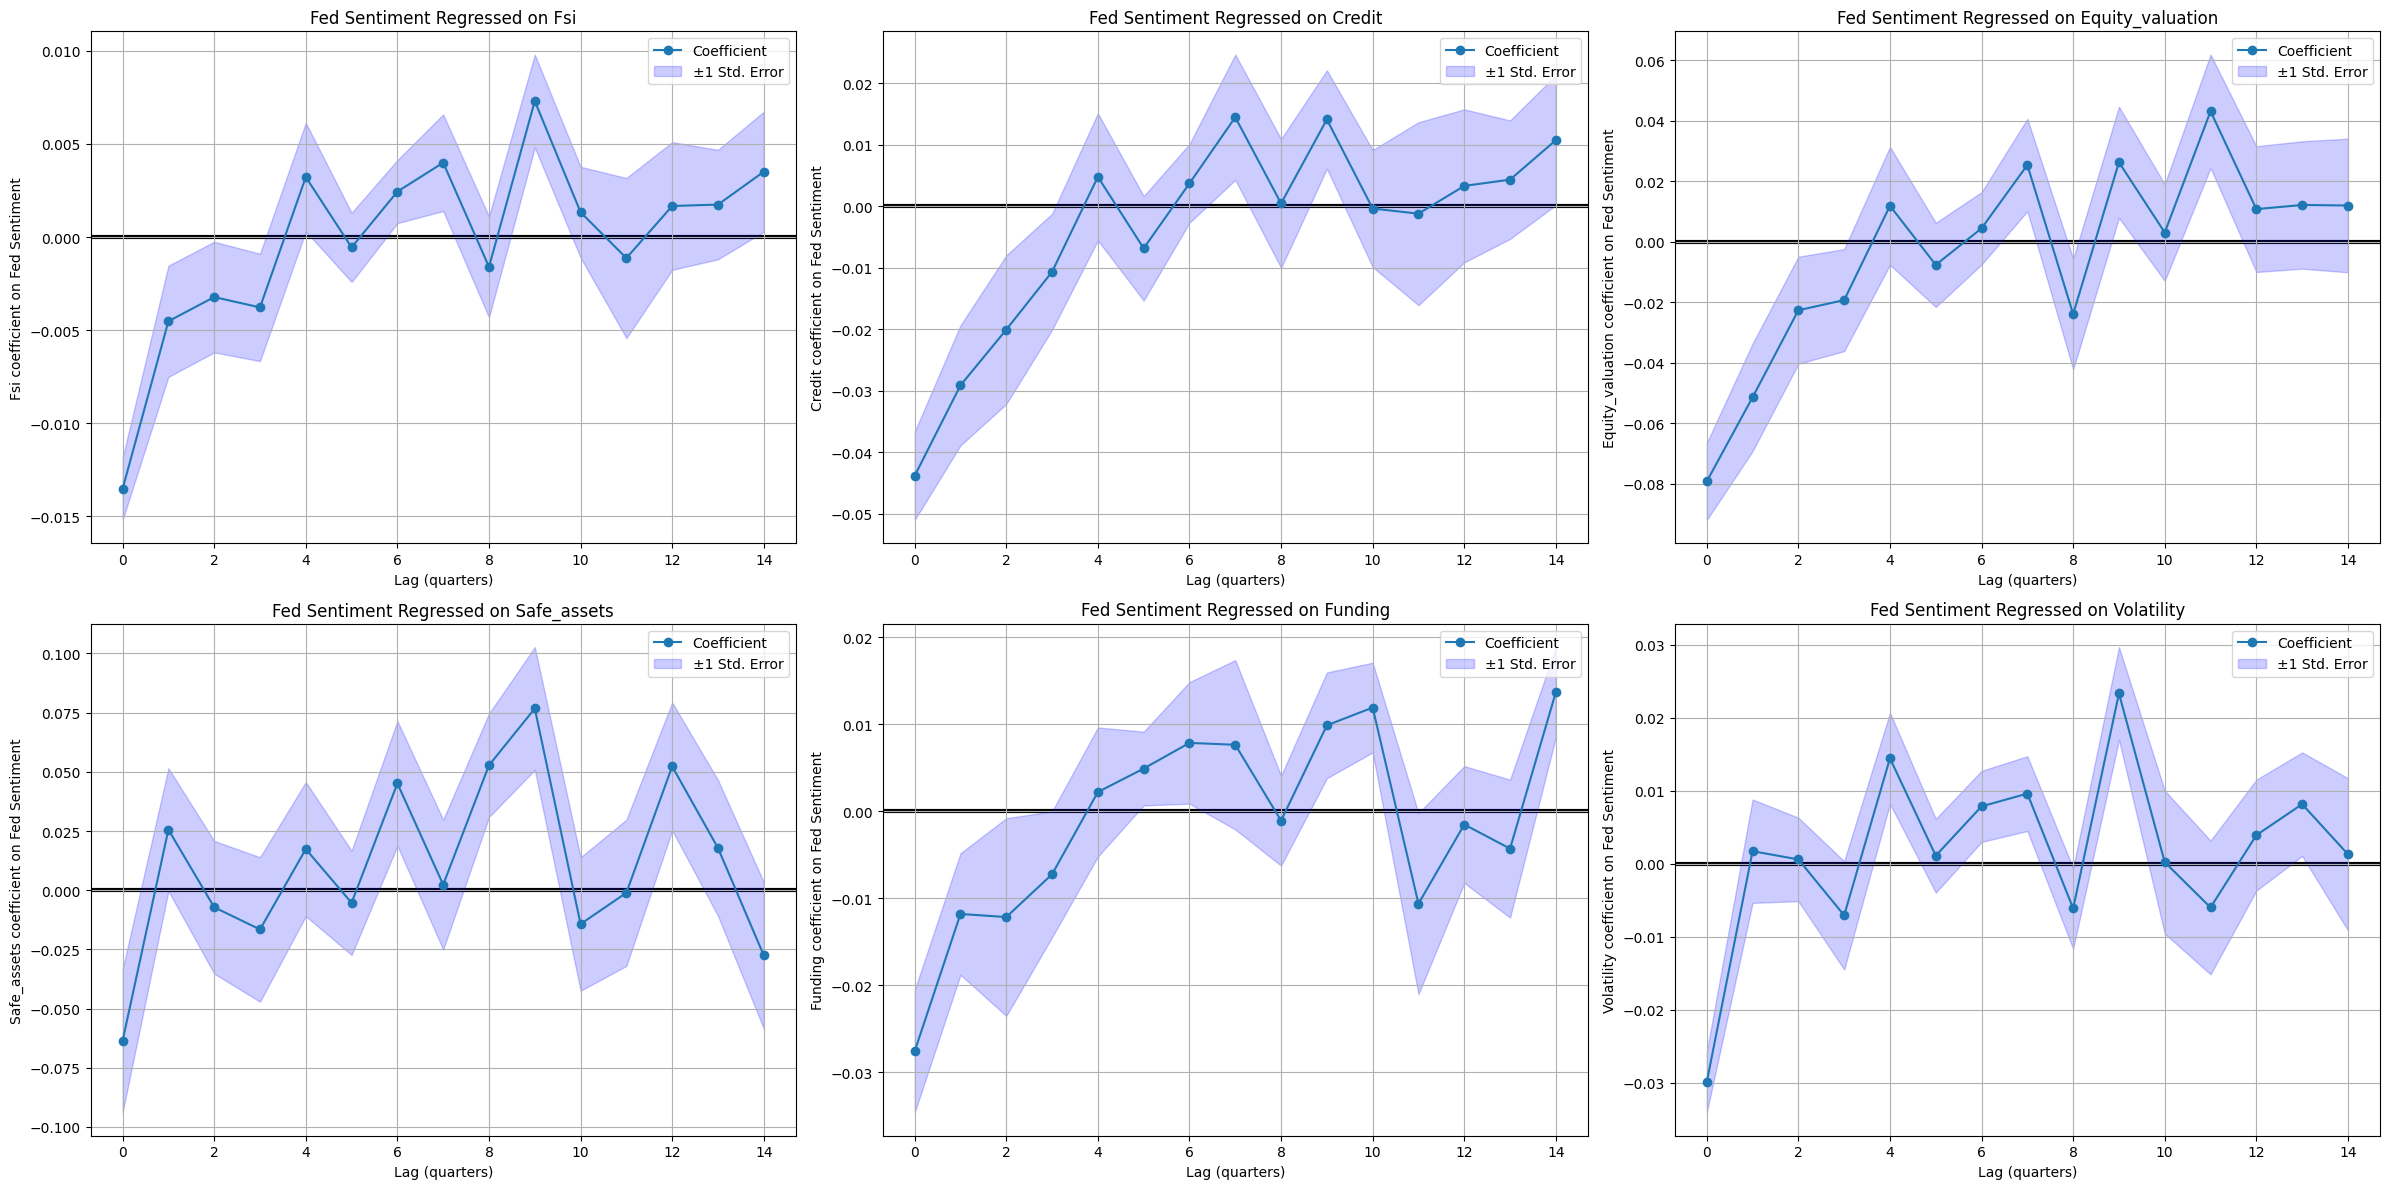

In [62]:
import matplotlib.pyplot as plt
import numpy as np

variables = [
    "fsi",
    "credit",
    "equity_valuation",
    "safe_assets",
    "funding",
    "volatility",
]

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten()

for idx, var in enumerate(variables):
    coefs = []
    ses = []
    lags = []
    for lag in range(max_lag):
        lag_1 = lag + 1
        var_lag = f"{var}_lag_{lag}"
        x = [
            f"{var}_lag_{lag}",
            f"{var}_lag_{lag_1}",
            "fed_minutes_lag_1",
        ]
        yvar0 = "fed_minutes"
        exog0 = sm.add_constant(sentiment[x]).dropna()
        y = sentiment[yvar0].loc[exog0.index]
        try:
            reg0 = sm.OLS(endog=y, exog=exog0).fit(cov_type="HC0")
            coefs.append(reg0.params[var_lag])
            ses.append(reg0.bse[var_lag])
        except Exception:
            coefs.append(np.nan)
            ses.append(np.nan)
        lags.append(lag)
    coefs = np.array(coefs)
    ses = np.array(ses)
    ax = axes[idx]
    ax.plot(lags, coefs, marker="o", label="Coefficient")
    ax.fill_between(
        lags, coefs - ses, coefs + ses, color="blue", alpha=0.2, label="±1 Std. Error"
    )
    ax.set_xlabel("Lag (quarters)")
    ax.set_ylabel(f"{var.capitalize()} coefficient on Fed Sentiment")
    ax.set_title(f"Fed Sentiment Regressed on {var.capitalize()}")
    ax.grid(True)
    ax.legend()
    # Add black bar at y=0
    ax.axhline(y=0, color="black", linewidth=3, zorder=0)

plt.tight_layout()